<a href="https://colab.research.google.com/github/krisster/Raif_Project/blob/main/Raif_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the problem of income predictions
*According to characteristics decide if an agent has an income higher or lower than 50 thousands*
* Downloading dataset 
* Analysis of missing values and wrong data

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


from google.colab import drive


import warnings
warnings.filterwarnings("ignore")

## Download data



In [ ]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

In [ ]:
!sudo apt update && sudo apt install --yes python3 python3-pip && \
!pip3 install psycopg2-binary

In [ ]:
import psycopg2

conn = psycopg2.connect("""
    host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
    port=6432
    sslmode=verify-full
    dbname=db_clients
    user=mlhs_student
    password=mlhs_student
    target_session_attrs=read-write
""")

In [ ]:
query = "SELECT * from public.adult_income"
df = pd.read_sql_query(query, conn)
conn.close()

In [ ]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25.0,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K


In [ ]:
df.shape 

(9615, 15)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9615 entries, 0 to 9614
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              8961 non-null   float64
 1   workclass        9615 non-null   object 
 2   fnlwgt           9615 non-null   int64  
 3   education        9615 non-null   object 
 4   educational-num  9615 non-null   int64  
 5   marital-status   9615 non-null   object 
 6   occupation       9615 non-null   object 
 7   relationship     9615 non-null   object 
 8   race             9614 non-null   object 
 9   gender           9614 non-null   object 
 10  capital-gain     9614 non-null   float64
 11  capital-loss     9614 non-null   float64
 12  hours-per-week   8543 non-null   float64
 13  native-country   9614 non-null   object 
 14  income           9614 non-null   object 
dtypes: float64(4), int64(2), object(9)
memory usage: 1.1+ MB


### Data collection

In [ ]:
df.to_csv("income_clients.csv", index=False)

## Data analysis

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/income_clients.csv")

### Quality of data

In [5]:
df.isna().sum()

age                 654
workclass             0
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation            0
relationship          0
race                  1
gender                1
capital-gain          1
capital-loss          1
hours-per-week     1072
native-country        1
income                1
dtype: int64

In [6]:
# delete the row, where income is nan
df = df.drop(df[df["income"].isna()].index)

In [7]:
result = df[df.applymap(lambda x: '?' in str(x)).any(axis=1)] 
result

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
4,18.0,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
6,29.0,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0.0,0.0,40.0,United-States,<=50K
13,58.0,?,299831,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0.0,0.0,35.0,United-States,<=50K
19,40.0,Private,85019,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0.0,0.0,45.0,?,>50K
22,72.0,?,132015,7th-8th,4,Divorced,?,Not-in-family,White,Female,0.0,0.0,6.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9543,20.0,?,49819,Some-college,10,Never-married,?,Own-child,White,Female,0.0,0.0,NaN,United-States,<=50K
9545,NaN,Local-gov,263690,Bachelors,13,Never-married,Prof-specialty,Unmarried,Black,Male,0.0,0.0,NaN,?,<=50K
9568,NaN,?,150250,Masters,14,Married-civ-spouse,?,Husband,White,Male,0.0,1510.0,NaN,United-States,<=50K
9573,NaN,?,305145,Bachelors,13,Widowed,?,Not-in-family,White,Male,0.0,0.0,NaN,United-States,<=50K


There are missing values in "age", "hours-per-week" and also in "workclass", "native-country" and "occupation". I decided to use different methods to fill nans. For the first case, with age, I just use median. Second thing, I decide to fill "workclass" and "occupation" using random forest. Third case "hours-per-week" will be filled according information from missed data by KMeans method.

<Axes: >

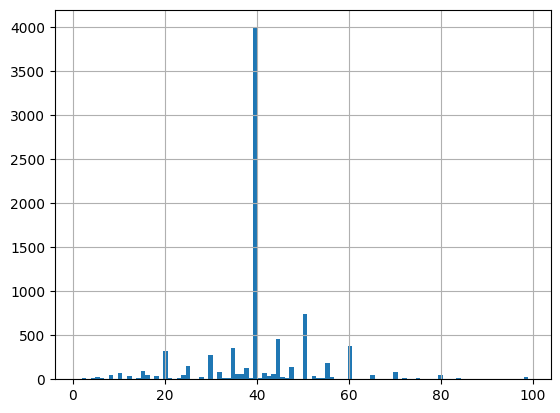

In [8]:
df["hours-per-week"].hist(bins=100)

In [9]:
median_age = df.age.median()
df["age"] = df["age"].fillna(median_age)

We can see that missong values in the variable "hours-per-week" is aboout 10%. Thus we have to fill this values with something. Looking at this histogram plot we can see that the most frequent value is 40 hours a day. So, put it instead of nan

However, there are cases, where values are hidden ("?"). Try to use a RandomForest method to fill missing values

### RandomForestClassifier

In [10]:
cat_features = ["education", "marital-status", "relationship", 
                "race", "gender", "income"] # "native-country", "workclass", "occupation"     

In [11]:
numerical_feat = ["age", "fnlwgt", "educational-num", 
                  "capital-gain", "capital-loss"]

In [12]:
df_change = pd.get_dummies(df, columns = cat_features)

In [13]:
mis_values = df_change[(df_change["occupation"] == "?") | (df_change["workclass"] == "?") | (df_change["native-country"] == "?")]

In [14]:
df_full = df_change[(df_change["occupation"] != "?") & (df_change["workclass"] != "?") & (df_change["native-country"] != "?")]
# df_full = df_full.dropna()

In [15]:
# drop hours-per-week because there are lots of nans, 
# but fill it according information from other columns
X = df_full.drop(columns = ["workclass", "occupation", "native-country", "hours-per-week"])
y = df_full["native-country"]

In [16]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)

RandomForestClassifier(random_state=0)

In [17]:
X_test = mis_values.drop(columns = ["workclass", "occupation", "native-country", "hours-per-week"])

In [18]:
mis_values["native-country"] = clf.predict(X_test)

In [19]:
df["native-country"].value_counts()

United-States                 8681
Mexico                         186
?                              164
Philippines                     51
Puerto-Rico                     41
Germany                         41
Canada                          34
India                           34
El-Salvador                     30
Cuba                            28
England                         21
Haiti                           20
Poland                          20
South                           20
China                           19
Dominican-Republic              18
Portugal                        18
Guatemala                       17
Jamaica                         15
Italy                           15
Columbia                        13
Ecuador                         13
Japan                           12
Peru                            11
Thailand                        10
Nicaragua                        9
Greece                           7
Vietnam                          7
Taiwan              

In [20]:
mis_values["native-country"].value_counts()

United-States         703
Mexico                 10
Philippines             9
India                   8
Columbia                2
China                   2
Guatemala               1
Peru                    1
Dominican-Republic      1
Name: native-country, dtype: int64

In some case the proportion between countries is saved. Thus, the tree gives not so random answers

In [21]:
df_new = pd.concat([df_full, mis_values])

Do the same things again for "occupation"

In [22]:
cat_features = ["native-country"]

In [23]:
df_change = pd.get_dummies(df_new, columns = cat_features)

In [24]:
mis_values = df_change[(df_change["occupation"] == "?") | (df_change["workclass"] == "?")]
df_full = df_change[(df_change["occupation"] != "?") & (df_change["workclass"] != "?")]

In [25]:
X = df_full.drop(columns = ["workclass", "occupation", "hours-per-week", "hours-per-week"])
y = df_full["workclass"]

In [26]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)

RandomForestClassifier(random_state=0)

In [27]:
X_test = mis_values.drop(columns = ["workclass", "occupation", "hours-per-week", "hours-per-week"])

In [28]:
mis_values["workclass"] = clf.predict(X_test)

In [29]:
df["workclass"].value_counts()

Private             6573
Self-emp-not-inc     782
Local-gov            609
?                    584
State-gov            429
Self-emp-inc         353
Federal-gov          279
Without-pay            4
Never-worked           1
Name: workclass, dtype: int64

In [30]:
mis_values["workclass"].value_counts()

Private             513
Self-emp-not-inc     44
Local-gov            16
Self-emp-inc          5
State-gov             5
Federal-gov           2
Name: workclass, dtype: int64

Again the proportion between categories is saved

In [31]:
df_new = pd.concat([df_full, mis_values])

And for "work-class"

In [32]:
cat_features = ["workclass"]

In [33]:
df_change = pd.get_dummies(df_new, columns = cat_features)

In [34]:
mis_values = df_change[(df_change["occupation"] == "?")]
df_full = df_change[(df_change["occupation"] != "?")]

In [35]:
X = df_full.drop(columns = ["occupation", "hours-per-week", "hours-per-week"])
y = df_full["occupation"]

In [36]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)

RandomForestClassifier(random_state=0)

In [37]:
X_test = mis_values.drop(columns = ["occupation", "hours-per-week"])

In [38]:
mis_values["occupation"] = clf.predict(X_test)

In [39]:
df["occupation"].value_counts()

Prof-specialty       1222
Exec-managerial      1213
Craft-repair         1183
Adm-clerical         1079
Sales                1065
Other-service         960
Machine-op-inspct     621
?                     585
Transport-moving      429
Handlers-cleaners     414
Farming-fishing       310
Tech-support          279
Protective-serv       194
Priv-house-serv        57
Armed-Forces            3
Name: occupation, dtype: int64

In [40]:
mis_values["occupation"].value_counts()

Other-service        128
Adm-clerical          94
Sales                 91
Craft-repair          57
Exec-managerial       47
Machine-op-inspct     36
Prof-specialty        32
Transport-moving      27
Handlers-cleaners     26
Farming-fishing       25
Tech-support          12
Priv-house-serv        6
Protective-serv        4
Name: occupation, dtype: int64

In this case the proportion is not the same. And I hope this is because it is one of the last category that allows to make predictions more carefully

In [41]:
df_new = pd.concat([df_full, mis_values])

In [42]:
df_new.shape

(9614, 92)

The last feature is "hours-per-week". Let's try to apply clusterization. Then according to classes I fill missing values of hours-per-week

In [43]:
cat_features = ["occupation"]

In [44]:
df_change = pd.get_dummies(df_new, columns = cat_features)

In [45]:
# Scale our values, use MinMax as we have categirical features
mms = MinMaxScaler()
mms.fit(df_change.drop(columns="hours-per-week"))
df_transformed = mms.transform(df_change.drop(columns="hours-per-week"))

In [46]:
# Elbow method to find an optimal numer of clusters
Sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_transformed)
    Sum_of_squared_distances.append(km.inertia_)

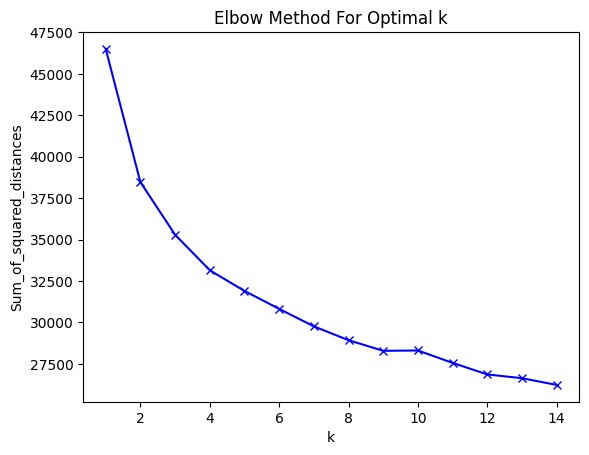

In [47]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

This is an elbow method even if we don't have a peak here. I will choose number of clusters = 7, as we can see, that we have lower additional qualuty here

In [48]:
kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(df_transformed)

KMeans(n_clusters=7, random_state=0)

In [49]:
df_change['cluster'] = kmeans.predict(df_transformed)

In [50]:
df_change["hours-per-week"] = df_change.groupby("cluster")["hours-per-week"].apply(lambda x: x.fillna(x.median()))

In [51]:
df_change.isna().sum()

age                            0
fnlwgt                         0
educational-num                0
capital-gain                   0
capital-loss                   0
                              ..
occupation_Protective-serv     0
occupation_Sales               0
occupation_Tech-support        0
occupation_Transport-moving    0
cluster                        0
Length: 106, dtype: int64

### Main characteristics

In [52]:
# There is a class disbalance
df['income'].value_counts(normalize=True)

<=50K    0.765134
>50K     0.234866
Name: income, dtype: float64

In [53]:
df.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,9614.000000,9.614000e+03,9614.000000,9614.000000,9614.000000,8543.000000
mean,38.604327,1.882948e+05,10.080092,1121.998232,87.926669,40.475126
std,13.362983,1.051352e+05,2.562733,7890.578253,404.085647,12.340030
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.154652e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.778450e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.374175e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


<Axes: >

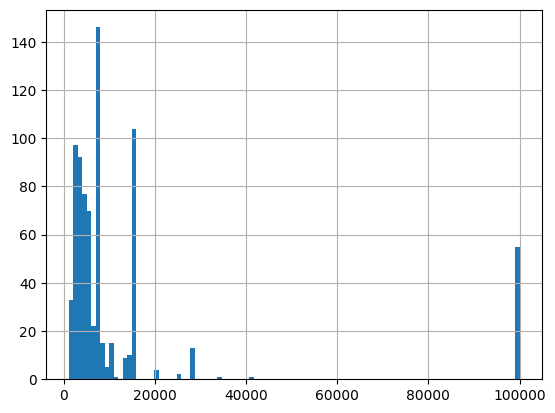

In [54]:
# We have some strange values for capital-gain - 99999
df[df["capital-gain"] > 1000]["capital-gain"].hist(bins=100)

In [55]:
df[df["capital-gain"] == df["capital-gain"].max()]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
79,44.0,Self-emp-inc,223881,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,99999.0,0.0,50.0,?,>50K
315,39.0,Private,198654,HS-grad,9,Divorced,Exec-managerial,Unmarried,Black,Female,99999.0,0.0,40.0,United-States,>50K
323,50.0,Self-emp-not-inc,165001,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999.0,0.0,80.0,United-States,>50K
482,54.0,Self-emp-inc,159219,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999.0,0.0,NaN,United-States,>50K
629,43.0,State-gov,125831,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,99999.0,0.0,60.0,United-States,>50K
788,44.0,Private,217039,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999.0,0.0,60.0,United-States,>50K
884,59.0,Self-emp-inc,77816,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999.0,0.0,40.0,United-States,>50K
1008,44.0,Private,120277,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999.0,0.0,60.0,United-States,>50K
1009,41.0,Private,191547,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999.0,0.0,NaN,United-States,>50K
1031,43.0,Private,115562,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999.0,0.0,50.0,United-States,>50K


All clients have income higher than 50K. So, they maybe do not want to say about additional gain. As this value seems strange, I decided just fill capital-gain by mean among people, who have income > 50K



In [56]:
mean = df_change[df_change["income_>50K"] == 1]["capital-gain"].mean()
df_change.loc[df_change["capital-gain"] == df_change["capital-gain"].max(), "capital-gain"] = mean

<Axes: >

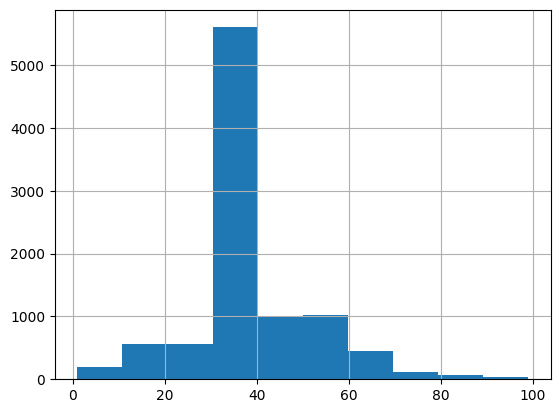

In [57]:
df_change["hours-per-week"].hist()

There is a small tail of distribution where clients work about 100 hours per week. Firstly, I think it is also an outlier. However, this might be true becuse it is not obvoius mistake (not more than 24$\cdot$7)

In [58]:
corr = df.corr()
corr.style.background_gradient()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.079232,0.002274,0.072331,0.049127,0.086708
fnlwgt,-0.079232,1.000000,-0.024398,-0.005989,-0.000409,-0.003148
educational-num,0.002274,-0.024398,1.000000,0.132639,0.083546,0.137757
capital-gain,0.072331,-0.005989,0.132639,1.000000,-0.030944,0.102024
capital-loss,0.049127,-0.000409,0.083546,-0.030944,1.000000,0.052580
hours-per-week,0.086708,-0.003148,0.137757,0.102024,0.052580,1.000000


There is no strong correlation between the predicted variable and features (correlation is less than 0.5)

## Model construction

### Logistic Regression

We'd like to predict the 'income' variable. Before I start modeling I should make the same scale for all variables

In [59]:
df_change = df_change.rename({"income_>50K" : "income"}, axis=1)
df_change = df_change.drop(["income_<=50K", "cluster"], axis=1)

In [60]:
# drop columns to eliminate possibility of collinearity
# [['income', 'education_Some-college','marital-status_Divorced','relationship_Husband',
#   'race_Amer-Indian-Eskimo','gender_Female', 'native-country_Cambodia',
#   'workclass_Federal-gov', 'occupation_Adm-clerical', 'cluster']]

[['income',
  'education_Some-college',
  'marital-status_Divorced',
  'relationship_Husband',
  'race_Amer-Indian-Eskimo',
  'gender_Female',
  'native-country_Cambodia',
  'workclass_Federal-gov',
  'occupation_Adm-clerical',
  'cluster']]

In [61]:
X = df_change.drop(['income', 'education_Some-college','marital-status_Divorced',
                    'relationship_Husband',
                    'race_Amer-Indian-Eskimo','gender_Female', 
                    'native-country_Cambodia',
                    'workclass_Federal-gov', 'occupation_Adm-clerical'], axis=1)
y = df_change["income"]

In [178]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, 
                                                y, 
                                                test_size=0.25, 
                                                random_state=42)

Let's use MinMaxScaler to standartize our data

In [179]:
mm = MinMaxScaler()
mm.fit(Xtrain)

MinMaxScaler()

In [180]:
Xtrain = pd.DataFrame(mm.transform(Xtrain), columns=X.columns)
Xtest = pd.DataFrame(mm.transform(Xtest), columns=X.columns)

In [65]:
Xtrain.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,education_10th,education_11th,education_12th,education_1st-4th,...,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving
0,0.082192,0.096254,0.400000,0.0,0.0,0.346939,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.150685,0.207249,0.133333,0.0,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.287671,0.015575,0.800000,0.0,0.0,0.479592,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.273973,0.445624,0.600000,0.0,0.0,0.448980,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.383562,0.192993,0.866667,0.0,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Also we have problem with class disbalance. I use oversampling because there is no so much rows in our data.

In [66]:
print("Before oversampling:\n", ytrain.value_counts())

Before oversampling:
 0    5514
1    1696
Name: income, dtype: int64


In [181]:
# define oversampling strategy
SMOTE = SMOTE()

TypeError: ignored

In [182]:
Xtrain_SMOTE, ytrain_SMOTE = SMOTE.fit_resample(Xtrain, ytrain)

In [69]:
print("After oversampling:\n", ytrain_SMOTE.value_counts())

After oversampling:
 0    5514
1    5514
Name: income, dtype: int64


In [183]:
model = LogisticRegression()
model.fit(Xtrain_SMOTE, ytrain_SMOTE)

LogisticRegression()

In [184]:
pred_test = model.predict(Xtest)

In [72]:
accuracy_score(ytest, pred_test) 

0.8065723793677204

In [73]:
pred_test[pred_test == 0].shape

(1555,)

In [74]:
pred_test[pred_test != 0].shape

(849,)

In [75]:
ytest.value_counts()

0    1842
1     562
Name: income, dtype: int64

In [ ]:
pickle.dump(model, open("logistic_model.pkl", "wb"))

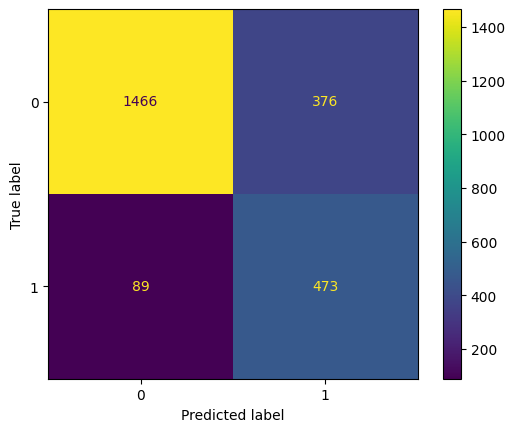

In [76]:
cm_log = confusion_matrix(ytest, pred_test)
cm_display = ConfusionMatrixDisplay(cm_log).plot()

$\text{accuracy}=\frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$

$\text{precision}=\frac{\text{TP}}{\text{TP} + \text{FP}}$

$\text{recall}=\frac{\text{TP}}{\text{TP} + \text{FN}}$

$F_1=\frac{2\cdot\text{precision}\cdot\text{recall}}{\text{precision} + \text{recall}}$

In [145]:
print("precision: ", precision_score(ytest, pred_test))
print("recall: ", recall_score(ytest, pred_test))
print("f1-score: ", f1_score(ytest, pred_test))
print("roc-auc: ", roc_auc_score(ytest, pred_test))

precision:  0.5571260306242638
recall:  0.8416370106761566
f1-score:  0.6704464918497519
roc-auc:  0.818755530310934


### What is the predicted variable???

In this case we can see, that precision is bad. It means that a model is bad in predictions for income < 50K

In [79]:
coef_table = pd.DataFrame({'features' : list(X.columns), 'weights' : list(model.coef_[0])})
coef_table.sort_values(by='weights')[:20]

,features,weights
88,occupation_Other-service,-1.783893
89,occupation_Priv-house-serv,-1.372243
28,relationship_Other-relative,-1.355191
7,education_11th,-1.287726
74,native-country_Vietnam,-1.247172
79,workclass_Self-emp-not-inc,-1.242942
54,native-country_Iran,-1.158348
68,native-country_Scotland,-1.134342
29,relationship_Own-child,-1.102053
12,education_9th,-1.066147


### SVM model

In [186]:
model=SVC()
clf_SMOTE = model.fit(Xtrain_SMOTE, ytrain_SMOTE)
pred_SMOTE = clf_SMOTE.predict(Xtest)

In [187]:
print("precision score: ", precision_score(ytest, pred_SMOTE))
print("recall score: ", recall_score(ytest, pred_SMOTE))
print("f1-score: ", f1_score(ytest, pred_SMOTE))

precision score:  0.5206243032329989
recall score:  0.8309608540925267
f1-score:  0.6401644962302948


In [82]:
print("ROC AUC score for oversampled SMOTE data: ", roc_auc_score(ytest, pred_SMOTE))

ROC AUC score for oversampled SMOTE data:  0.7940850305833439


In [188]:
pickle.dump(model, open("svm_model.pkl", "wb"))

### Cat boost

In [83]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.9 MB/s eta 0:00:00


In [ ]:
!pip install ipywidgets

In [87]:
from catboost import CatBoostClassifier, Pool

In [90]:
X.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,education_10th,education_11th,education_12th,education_1st-4th,...,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving
0,25.0,226802,7,0.0,0.0,40.0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,38.0,89814,9,0.0,0.0,50.0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,28.0,336951,12,0.0,0.0,40.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,44.0,160323,10,7688.0,0.0,40.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,34.0,198693,6,0.0,0.0,30.0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [171]:
cat_features = list(range(6, X.columns.shape[0]))

In [172]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, 
                                                y, 
                                                test_size=0.25, 
                                                random_state=42)

In [173]:
train_set = Pool(Xtrain, ytrain, cat_features=cat_features)
test_set = Pool(Xtest, ytest, cat_features=cat_features)

In [174]:
gbm = CatBoostClassifier(iterations=200,
                          depth=5,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, 
        eval_set=test_set,
        plot=True
        )
gbm_preds = gbm.predict_proba(Xtest)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

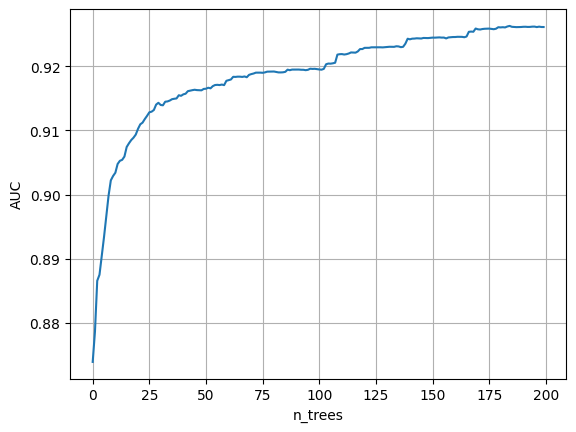

In [175]:
eval_metrics = gbm.get_evals_result()
plt.plot(eval_metrics['validation']['AUC'])
plt.xlabel('n_trees')
plt.ylabel('AUC')
plt.grid()

In [137]:
y.value_counts()

0    7356
1    2258
Name: income, dtype: int64

In [138]:
2258 / (2258 + 7356)

0.23486582067817766

In [176]:
gbm_classes = (gbm_preds[:, 1] > 0.25)
print("precision: ", precision_score(ytest, gbm_classes))
print("recall: ", recall_score(ytest, gbm_classes))
print("f1-score: ", f1_score(ytest, gbm_classes))
print("auc-roc: ", roc_auc_score(ytest, gbm_preds[:, 1]))

precision:  0.5890243902439024
recall:  0.8594306049822064
f1-score:  0.6989869753979738
auc-roc:  0.9263029315960912


In [177]:
pickle.dump(gbm, open("catboost_model.pkl", "wb"))

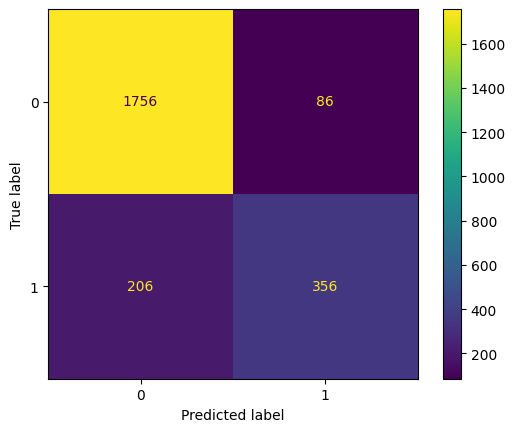

In [146]:
cm_cb = confusion_matrix(ytest, gbm_classes)
cm_display = ConfusionMatrixDisplay(cm_cb).plot()

### Cat boost with optuna

I'd like to try to make predictions better. For this propose I use optune, a packet that allows to find the most appropriate hyperparameters

In [149]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.7 MB/s eta 0:00:00


In [150]:
import optuna
import pickle

In [164]:
def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        verbose=False
    )
    model.fit(Xtrain, 
              ytrain,
              eval_set=[(Xtest, ytest)],
              # eval_metric='AUC'
              )
    y_pred = model.predict(Xtest)
    return f1_score(ytest, y_pred)

In [165]:
from optuna.samplers import TPESampler

optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", 
                            direction="maximize", 
                            sampler=sampler)
study.optimize(objective, n_trials=200)

In [166]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  200
Best trial:
  Value:  0.7170923379174853
  Params: 
    iterations: 944
    learning_rate: 0.052372315418571944
    depth: 4
    l2_leaf_reg: 4.941753952002075e-05
    bootstrap_type: Bayesian


In [167]:
model = CatBoostClassifier(**trial.params, verbose=False)
model.fit(Xtrain, ytrain)
y_pred = model.predict(Xtest)

In [168]:
print(f1_score(ytest, y_pred))

0.7121951219512195


In [170]:
pickle.dump(model, open("catboost_model_optuna.pkl", "wb"))